## Perturbation of sequences
### Dataset: Coronaviridae S Protein sequences of Humans only
### Number of sequences = 2400
### Model: Transformer

In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/..']

In [4]:
from prediction.models.nlp import transformer, transformer_model, cnn1d, lstm, fnn
from prediction.datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, nn_utils
from src.utils.nlp_utils.padding import Padding
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts_human.csv"
output_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230917/perturbed_dataset_prediction/transformer-l_6-h_8-lr1e-4/processed"
models_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230908"


uniprotkb_coronaviruses_human_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

test_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 1,
    "max_sequence_length": 1453,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1453,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

In [4]:
uniprotkb_coronaviruses_human_df

id                                                seq  \
0     P0DTC2  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
1     P15423  MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...   
2     P36334  MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...   
3     Q0ZME7  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   
4     Q14EB0  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   
...      ...                                                ...   
2395  T1PZ80  MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPT...   
2396  T1PZ81  MFLILLISLPTAFAVIGDLNCPLDTRLKGSFNNRDTGPPSISTDTV...   
2397  T1PZ82  QADSFTCNNIDAAKIYGMCFSSITIDKFAIPNRRKVDLQLGNLGYL...   
2398  T1PZ83  MFLILLISLPTAFAVIGDLNCPLDPRLKGSFNNRDTGPPSISTDTV...   
2399  U3PXJ8  TYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIP...   

                                                  virus  seq_len  \
0     Severe acute respiratory syndrome coronavirus ...     1273   
1                    Human coronavirus 229E (HCoV-229E)     1173   
2                    Human coronavirus OC43 (HCoV-OC43)     1353   
3       Human coronavirus HKU1 (isolate N5) (HCoV-HKU1)     1351   
4       Human coronavirus HKU1 (isolate N2) (HCoV-HKU1)     1351   
...                                                 ...      ...   
2395                 Human coronavirus NL63 (HCoV-NL63)      643   
2396                 Human coronavirus OC43 (HCoV-OC43)      929   
2397                 Human coronavirus OC43 (HCoV-OC43)      297   
2398                 Human coronavirus OC43 (HCoV-OC43)      933   
2399                 Human coronavirus 229E (HCoV-229E)      585   

                              virus_host binary_label  
0     Homo sapiens (Human) [TaxID: 9606]        Human  
1     Homo sapiens (Human) [TaxID: 9606]        Human  
2     Homo sapiens (Human) [TaxID: 9606]        Human  
3     Homo sapiens (Human) [TaxID: 9606]        Human  
4     Homo sapiens (Human) [TaxID: 9606]        Human  
...                                  ...          ...  
2395  Homo sapiens (Human) [TaxID: 9606]        Human  
2396  Homo sapiens (Human) [TaxID: 9606]        Human  
2397  Homo sapiens (Human) [TaxID: 9606]        Human  
2398  Homo sapiens (Human) [TaxID: 9606]        Human  
2399  Homo sapiens (Human) [TaxID: 9606]        Human  

[2400 rows x 6 columns]

<AxesSubplot:xlabel='seq_len', ylabel='Count'>

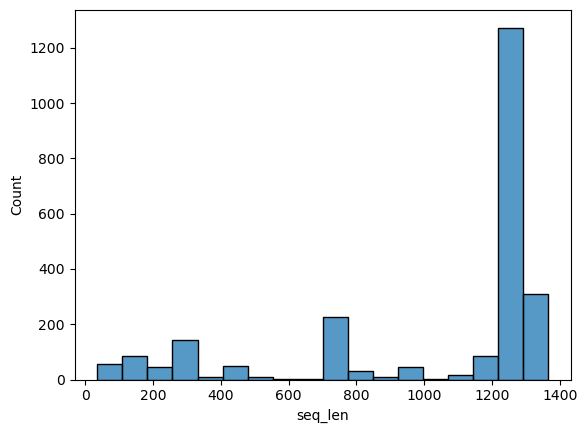

In [5]:
sns.histplot(uniprotkb_coronaviruses_human_df["seq_len"])

In [6]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(uniprot_id):
    id_df = uniprotkb_coronaviruses_human_df[uniprotkb_coronaviruses_human_df["id"] == uniprot_id]
    print(f"Size {uniprot_id} df = {uniprotkb_coronaviruses_human_df.shape}")
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

### Load the model

In [7]:
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-4-e50", "transformer-custom-l_6-h_8-lr1e-4_itr0.pth")))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=7, b

In [8]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [9]:
output_files = os.listdir(output_dir)
len(output_files)

2400

In [10]:
mean_diff_dfs = []
for output_file in output_files:
    regex_result = re.search(r"tf\_coronaviridae\_top\_7\_hosts_human\.csv\_([A-Z0-9]+)\.csv", output_file)
    uniprot_id = regex_result.group(1)
    uniprot_id_df, index_label_map, dataset_loader = get_dataset_loader_for_seq(uniprot_id)
    
    # do analysis for only sequences with length >= 1200
    uniprot_id_seq = uniprot_id_df["seq"].values[0]
    if len(uniprot_id_seq) < 1200:
        continue
    
    inputs, output_df = validate(tf_custom_model, dataset_loader, index_label_map)
    perturbed_output_df = pd.read_csv(os.path.join(output_dir, output_file))
    
    orig_seq_human_pred = output_df["Human"].values[0]
    perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
    perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
    pivot_df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")
    mean_diff_dfs.append(pivot_df.mean(axis=0))
    

Size A0A8B6RME8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QCK9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U0L300 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCE5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDH8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AU20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVL8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RWP2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A482KB25 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JF30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9M5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6H1W2H2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHG5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JXL2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JYJ0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HFX5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G3W0Q0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RK18 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N687 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QCJ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6V9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RGR1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G9HF12 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RI11 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JR94 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HFQ9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YA13 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RNI3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G5B0B7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G7WEE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RFB6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YG78 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size U3M6Y8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRF4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size U3M7N4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3DZQ7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KFM7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q4G1G3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y8H9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6H1W0J3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLB4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RBS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T5F0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDG9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JLN3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RBZ4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KUA2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATC5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H603 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G9U0L6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RHL7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7M3V771 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U0FC43 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RH64 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JWQ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JN20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EBU0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCN0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QAD0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1BGT8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q0ZJI1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KWA2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y8W0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YA60 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7L6WPR3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size S5YAI3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATX1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HHP9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MRY6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YAN9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JNU6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YC17 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JH90 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JSC3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RC03 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A858Z311 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384RHS8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D7W9F8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M5SX93 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A384QZE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7W0I8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N604 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A891F0G7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1BH40 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EQA4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JGA6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YG31 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RG54 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size H1AG31 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JY67 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JV53 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5B9MU35 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JQX6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZNY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDF2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A883GPT7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GE20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A891F0I3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RL37 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D7NUV9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KPK8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M6REN8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JJS4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q0QJI9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2P1E918 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A891GJY5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3MRZ9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G6GHW3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDY3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E939 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899KHW2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4Q7Z0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLT4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3RIT3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A890VB37 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8F4Q8K7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMJ5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE13 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ASX3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT46 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M6D6J7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRG4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVK8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFA9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JXR4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLH6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D7KRT4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9E4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDI6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2R3TWV1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJV4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDE7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RCU4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HJP7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0K0L9E5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RNL9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7M4C334 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RP06 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A897EF70 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9C8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1W6E034 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RA42 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G2Z6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9Z4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVM0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J806 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDG7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JL13 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2P1E952 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K2S5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RLM8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJB8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RWJ4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EDH8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5T257 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E912 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D5A044 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JDS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5B9MUE4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCB2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATX6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3E003 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCF7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJ82 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3MS26 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8P3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5B9BHU7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCA1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899KN30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1P9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RIN0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y848 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1L6M0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCA3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K969 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YA03 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VFW5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7T8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y9H4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q19U37 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1LC10 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G7K2M4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3MRE8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATT4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5TKZ1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M7L8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R8P8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y802 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size S5YGT1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HDA5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A7LIZ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLP5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size H9EJ16 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9N0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLZ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RNC0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6N0W0B0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HGQ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RAV3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JY15 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5T5F8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K4L8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATV2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMH1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJN9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A2MYZ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R9R3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HGW3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7M4C333 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A2S7L7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K463 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDI2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RKF1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EDW1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLA1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3ELP9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RL11 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H5S2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EVD3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1DC76 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6H1XPS1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384RK26 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K027 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATZ7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A679G9E9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VCW8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0E0Z3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE12 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1L890 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L5PL73 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QCI9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HCW3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K1Z8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6REK3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U1BH18 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HDU0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RBJ5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M3HLG5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M3SPN0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEW6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size I4DEX0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E915 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U1M9P9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K140 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5T1W7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U0T2C3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RBH7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JSS7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A860YZY5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EVE7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RW32 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MRH5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size H9EJW4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1F5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YBP4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N6L4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M4B9C2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A5RD35 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HHN1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A140H1H9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size H9EJ51 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QAE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B0G593 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATP6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7M4C330 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K6V9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y870 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVK9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9P7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JGT9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AUJ0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATL1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JLE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5T1L4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MWV7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J903 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JXE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATD7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9K3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K8K8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JGW7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A4L516 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAK7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AT67 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JH05 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PYX9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G7LM65 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size M1PF06 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCQ5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1BH50 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JI82 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HE66 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JKD4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JDK8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YLP3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RVE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YAA5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDF4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KJL1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJ38 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y9Z2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y8D5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6H1PMM5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1G1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size I4DEX1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVL0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y9A1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JNH3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K5C1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RX64 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size S5YGU2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K2L8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YLF3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G2Z3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1DBZ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N5Z0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBH1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVM3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PZ59 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7H2DTM2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZDZ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JL81 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JDS3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q4G1G0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGV9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1CW16 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATZ5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y9R1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6B6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDI0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PZ61 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VE68 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YG42 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RK04 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RM04 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7H4JBY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIA3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N5Z6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HDX2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899KD51 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q5MQD0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A3S6FHR2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFB4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GE24 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9Q4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7T8Q3C3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JPH7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K0U1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDW6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3H6A7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9G8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JM60 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5TMT7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q0QJI8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6Z3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDH9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3W8S5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7H4J8H0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9H1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K6D5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGV1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RKJ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K2F5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GE05 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899JZ39 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JR99 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G3W0P6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0PL04 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DZD0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RNW4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U0FD30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GE06 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HH46 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4VEM5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PZ36 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCK5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7P9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMD0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1HDL1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QAD6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1L7H999 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCI3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JGY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YAD8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6B9XJC0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RCE5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZKY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N7I9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RC94 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JEY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1F6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D8AJB5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1F7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JI19 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHV4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y8A8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size K4P2Y7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M4SWN5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKG8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QAE5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDF6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JEE6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T6J4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JI33 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A2SDZ7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YF87 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H5W2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z4HFJ9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8C8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDF7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K305 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RK97 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKY6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1XVY9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6H2LCL7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AWP3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D8AIA7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4ZK73 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T8HBN7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KWW1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATL4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N7I3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8S4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A867RQ58 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RUQ9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YFC8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDY1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y9F2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6B2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JT02 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRB9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VEL0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A8WYC4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AX91 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VFW7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YC65 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VE59 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JF55 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9Q2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7L9W1C3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBQ4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JSU1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M9TYL7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RG42 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDI4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y859 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K0H1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JDP8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHT7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7M4C332 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RVC4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A891F0C9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JBP8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size U3M7Q0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G5ZVU5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RAQ9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5B9MRW3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JDH2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RK40 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6HGV4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J5Y9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G3W0Q1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JJI7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7H4JBV8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KVP9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HF20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RGA2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RHU4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVL3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RS06 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JQS2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5T6M3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8G4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0Q9P5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3ECD3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KLD1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A886NC56 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N716 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E917 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RDF4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K9C9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JW21 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RP71 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDY0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RG66 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0E0W0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KBD9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J9K4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G9ZWU8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A883GPB1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EBH7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JRM6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5TE52 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K9B9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0P0HQR0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2P1E913 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMC4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RGC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9T2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JY50 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3NAI2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JW33 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDX9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KVF5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K2L0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A8HMN8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT43 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D5JZ01 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RF44 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7L4YH07 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G3XWA4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VE64 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N5Y2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0G2RC93 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6P3CTT1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KKE5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0K0L9B0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G2X7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JX30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RKU4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT81 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JN83 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6KVE6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JBB4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EVS4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0Q9H2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0P0HWR1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0P0HL64 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A3S6FJG2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6REZ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A883GQA5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EVL6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JPB5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JHC2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRT4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QCJ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RWL8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6REM7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDG9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JVQ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HP67 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899KK42 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HJV4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K156 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8R1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K350 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XP0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3ECU6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JYH4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7L8K8V5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JAI5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4ZF90 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8F4Q3L3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y7H4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3H686 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J9L0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H6K1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJI9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATP7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCC3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RX82 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1D0J1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIE4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDI3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L5PIU7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5B9MUZ1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6H1PJZ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N6L9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJB0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A897FM41 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U0TJY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A513ZT30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVM1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q06XM9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBT9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G2Y8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDF3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6H0JQ80 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1LAE4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JIC8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1X2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7L9W4Q0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VE61 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDH8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T5B8R5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6B9UZU2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y957 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RT25 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAR4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCD5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YG64 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0G2RC97 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLX9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATL2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JJK4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RHR5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RUR5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A883GPJ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T5UEM2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A8E2W1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6H2L6Y7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J874 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size I4DEY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KR97 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K0J3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1S5VGH2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLY4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HGS1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7H0C3W6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDF5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KR85 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8R5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6KR27 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5TE28 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size I4DEY7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T265 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDW7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RA95 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q4G1G5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1S5VGK6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N7J1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VT27 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JX35 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RF08 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JJD1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAI1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7M1Y488 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T0YN88 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K4A0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCA7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JP63 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A482KES2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JKS8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFY5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QAE7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J2Z7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJ74 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9X0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899JXB2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S9PHP5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K5X1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K5T2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K9D3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384RNP7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899KN36 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5B9MUX5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A8S576 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMQ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1CW27 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMB2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6N0C4S6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7M4C331 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y8X3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A895ZXI6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M4T375 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JKE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMZ9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384RBV6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q0QJJ1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899JZS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1W6E033 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZK83 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YBW2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGW7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6G9ZXC8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6Z9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RL78 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K4F5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RWV0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RM80 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RKC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVK2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B0GA47 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JCH0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HEG2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VEI7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A886NG07 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RK54 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AVA4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4UE97 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VFV9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JN81 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6KRH9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RHC2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K2F8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KTW7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K347 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D5A036 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K540 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5TGM6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RA66 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KV69 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JIP4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RE35 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y976 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MS61 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A858Z325 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L9W6W9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1CWK2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A224AU27 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size T1PZ83 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATD0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3ELV3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A859GTA2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A482KBY9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RWG4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VFW4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N5X3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RA18 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATK6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JIA6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1G2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JMZ7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZF60 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1LGI8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RX26 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFL8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EFZ1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T6Y5W2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4VC20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R900 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M6M126 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLG4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0P0GRR3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6S0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YC07 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATY9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KRW0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VEI9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q19U39 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RFC8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EEK0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q19U40 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RHJ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATX9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RAY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RD16 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q19U49 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KKM8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8F4SU81 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A896A1D6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size I4DEY4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1R1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0YL58 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T5QW37 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3MR70 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6B9UZ68 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YBS7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899K663 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1L6Y1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L5PKS3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A140E065 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size C1J1E9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JZV3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0E0Z4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q0QJI7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0P0HZF4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1C8Z4S1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A6UA14 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QAF0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A2KZJ1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VFV7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A482K8T8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K1J3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1CY48 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HEP0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMP2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8K0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899JFB4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y944 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJ02 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AWV2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size P15423 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JYD7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6N1WAZ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RKR1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EFC2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATK1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCP3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A384RJY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1L7H9A4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K9W0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EFL9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A873P8T4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAM8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KVE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JVX5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JIJ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size H9EJ44 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YGC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QCI6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899KBL9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6H2EIN2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8F4SVM3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M7L4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJK3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YEY5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATC3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J3W5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RWD6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRK7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JEK2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EFD9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0Q9G8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9P9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K796 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YL80 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JF74 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7K8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q6Q1S2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDW8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RT48 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE09 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RRX0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VE73 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6H9Y4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YGA2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EDI5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JHH4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCA9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G302 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RBS0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VEK7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HFE5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDE0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JCD7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8F4N344 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMY1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H631 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JWM8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HFV5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EL17 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ASX5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A5RU68 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMN9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RXD8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HFJ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KE84 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AV90 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1IT83 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JLN2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KPB7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K5S0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JBT4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6B6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size H9EJA0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size S5ZBP3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RKP4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T1L5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4VL67 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MRK2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HD14 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHM9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size T1PZ49 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9J1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y898 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVL1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT82 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A3S6FHK6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E936 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JFZ0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y931 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YC86 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q0QJI6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A3HA81 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899JDD3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R912 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A873P8X9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K130 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MRK6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JWX8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9G1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AUC9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EE76 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0Q9H3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7Z3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DVT4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A2GT99 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6K8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1S5VGE0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YG20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JKZ7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JAR8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2D1CLQ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M8FA80 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4VEK1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJ60 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JRW3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z4HFS2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AT72 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0P0HVI5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AU39 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE18 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JR33 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J5M2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N711 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JXY4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JTD6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JHK5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3RJ55 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JYT9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3ED34 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RP47 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DWB6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y7F5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L7QTX2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M4BCC7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L5PIV9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6N1WF48 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U0F9P7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0K0L8I8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JBU8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATW6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JH73 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N6A9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT74 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATG6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLE1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R8H6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T6C2X5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLB2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A8E2W0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RM54 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M701 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D3YBD3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGV2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HD31 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCC7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0P0HDK1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEY3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K045 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JLH2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJU6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JWX0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U1BGV5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size C1J1F1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D3R3D6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KWM6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6N0I6B2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AWE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6H9X8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1GCL2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q696P8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y883 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q06Y10 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RB60 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JZB8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T5UE84 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R9S2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KUX7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0K0KPR8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RRA4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RCR1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M4N1Z2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size T1PZ82 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AU01 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3ECL4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGT8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0P0G321 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A059SGA9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AU10 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KKS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YA76 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L5PM56 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899JGN9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATW1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JH79 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9N4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q5SBN8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4VIF0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JI01 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9G6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JB18 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DVW8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6HGU6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YF16 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDG7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9Y5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KGQ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J2D6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A3S6FHI0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKZ5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RLH0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EES1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JRT9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1S5VGL6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R9W1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CWI9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N708 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAE8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M6DCW9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCL8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A2QH78 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1YA24 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YL70 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT14 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K4T2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KW39 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VFW1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RIA7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RHE0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YL91 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATN7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JZI2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A3ZKI0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G3W0Q5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RBV2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EFK5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YAM8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMQ0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6HGX0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H6T1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JD97 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8X0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size P36334 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JR30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U1BH66 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEY6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDI2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1BGZ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A385H6K9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size G5CJB9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JCN6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8T4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YLK1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RQW0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6HGU9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VBU3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1DBD7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size T1PZ35 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G7S658 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1CW15 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0YKA3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J475 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RI40 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RWW8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6A4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A886MZM0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

In [11]:
output_df

Bovine   Chicken     Human  Japanese pipistrelle  Lesser bamboo bat  \
0  0.012806  0.000008  0.975468              0.000124           0.000269   

        Pig  Wild turkey y_true  
0  0.003223     0.008103  Human

In [12]:
perturbed_output_df

Human          id orig_token  perturb_pos new_token  pred_diff
0      0.975458  A0A1Y0EV12          H          150         D  -0.000010
1      0.975445  A0A1Y0EV12          I          215         Q  -0.000022
2      0.975489  A0A1Y0EV12          L          134         B   0.000022
3      0.975486  A0A1Y0EV12          L           11         A   0.000018
4      0.975488  A0A1Y0EV12          R          817         M   0.000020
...         ...         ...        ...          ...       ...        ...
33871  0.975437  A0A1Y0EV12          A         1089         W  -0.000030
33872  0.976550  A0A1Y0EV12          S          839         X   0.001082
33873  0.975530  A0A1Y0EV12          L         1246         T   0.000062
33874  0.975499  A0A1Y0EV12          G         1149         K   0.000032
33875  0.975530  A0A1Y0EV12          V          147         E   0.000062

[33876 rows x 6 columns]

In [13]:
df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")

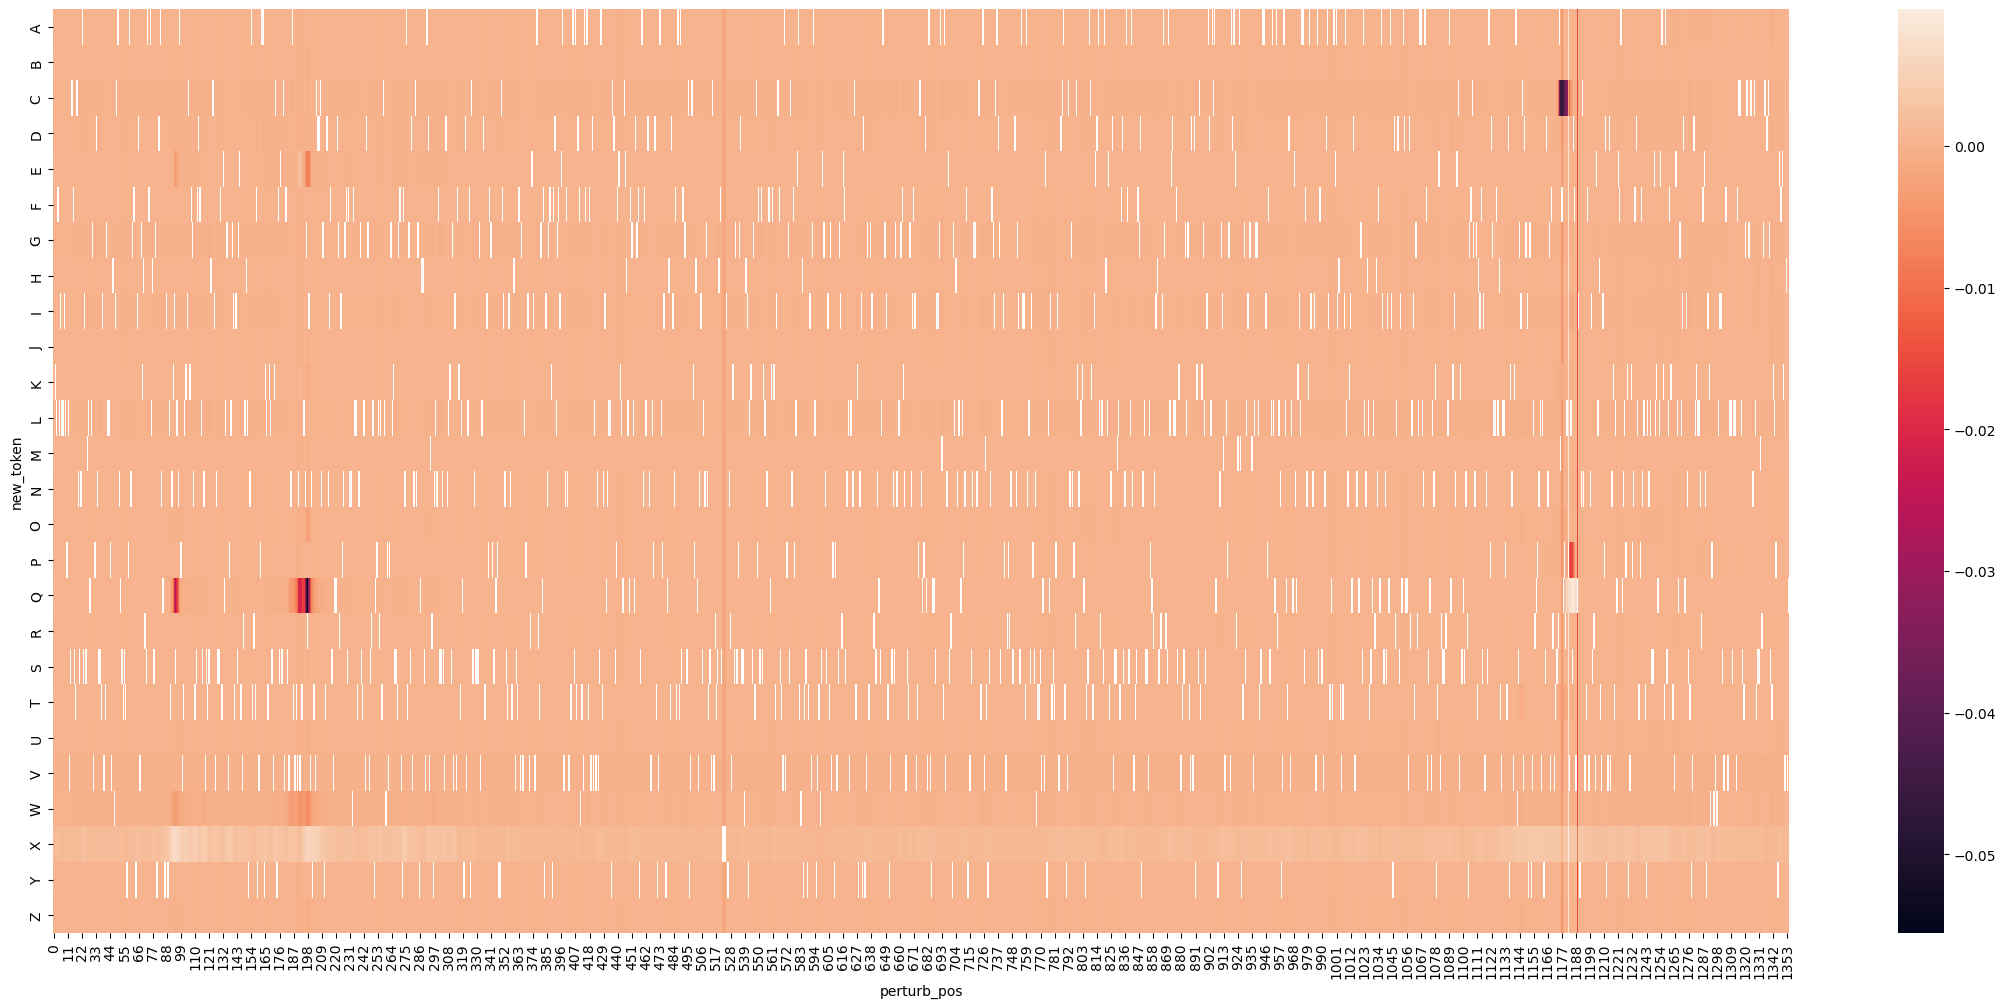

In [14]:
plt.figure(figsize=(28,12))
sns.heatmap(df)
plt.show()

In [15]:
df.mean(axis=0)

perturb_pos
0       0.000024
1       0.000043
2       0.000082
3       0.000053
4       0.000077
          ...   
1350    0.000023
1351    0.000156
1352    0.000038
1353    0.000177
1354    0.000019
Length: 1355, dtype: float64

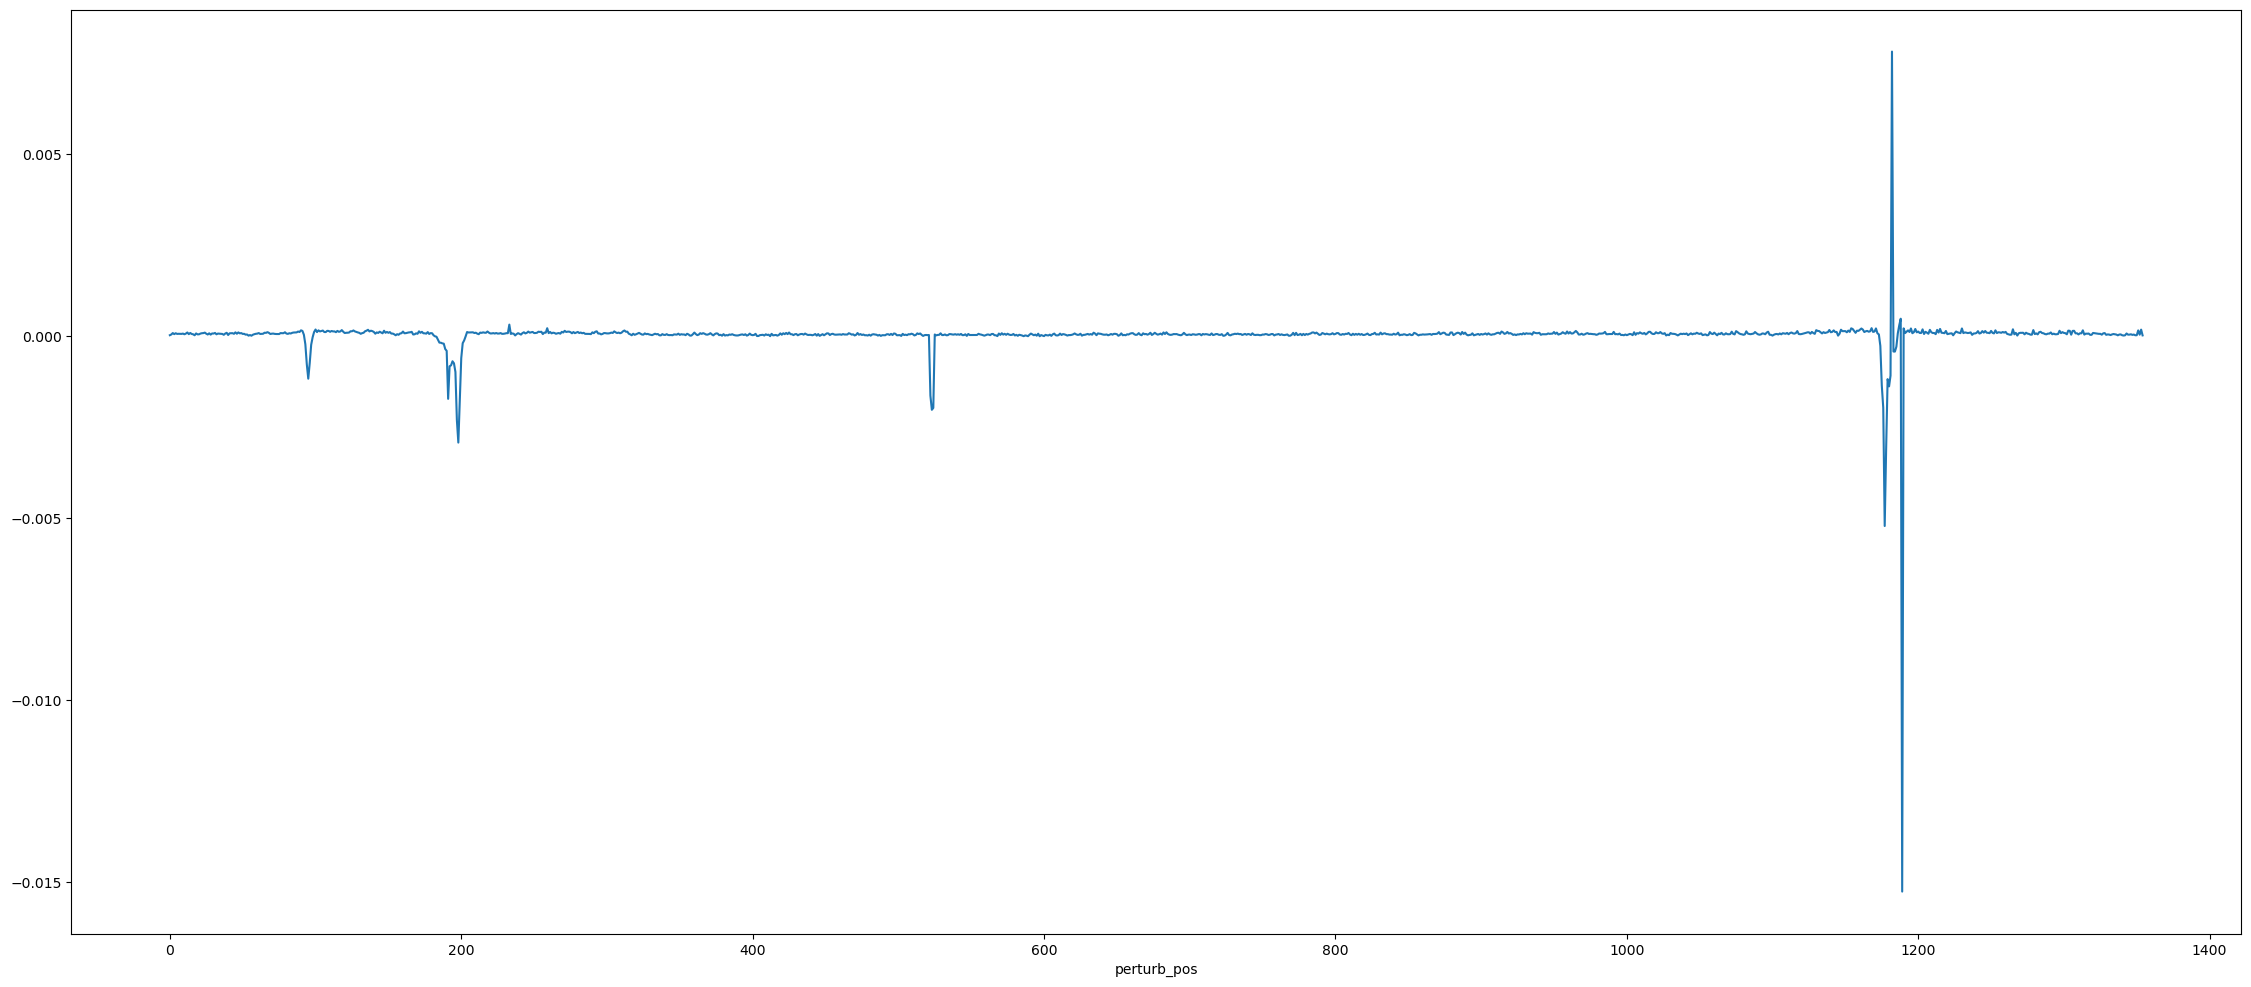

In [16]:
plt.figure(figsize=(28,12))
sns.lineplot(df.mean(axis=0))
plt.show()

In [17]:
df.mean(axis=0).idxmin()

1189

In [18]:
mean_diff_dfs

[perturb_pos
 0       2.210775e-05
 1       1.745799e-06
 2       1.367100e-05
 3       1.326460e-05
 4      -2.187300e-05
             ...     
 1234    3.774180e-05
 1235   -8.314015e-07
 1236   -1.380500e-05
 1237    3.518420e-05
 1238   -1.678540e-05
 Length: 1239, dtype: float64,
 perturb_pos
 0       0.000240
 1       0.000284
 2       0.000152
 3       0.000296
 4       0.000199
           ...   
 1268    0.000383
 1269    0.000338
 1270    0.000394
 1271    0.000643
 1272    0.000702
 Length: 1273, dtype: float64,
 perturb_pos
 0       1.165106e-05
 1       8.980242e-06
 2      -1.214096e-05
 3       6.271842e-06
 4       1.482417e-07
             ...     
 1268    4.557944e-05
 1269    2.102944e-05
 1270   -1.359936e-05
 1271    2.678504e-05
 1272   -1.000736e-05
 Length: 1273, dtype: float64,
 perturb_pos
 0       0.000010
 1       0.000008
 2      -0.000008
 3       0.000006
 4       0.000001
           ...   
 1268    0.000040
 1269    0.000014
 1270   -0.000015
 1271    0.

In [19]:
mean_diff_df = pd.DataFrame(mean_diff_dfs)

In [20]:
mean_diff_df

perturb_pos      0         1             2         3             4     \
0            0.000022  0.000002  1.367100e-05  0.000013 -2.187300e-05   
1            0.000240  0.000284  1.515489e-04  0.000296  1.986129e-04   
2            0.000012  0.000009 -1.214096e-05  0.000006  1.482417e-07   
3            0.000010  0.000008 -7.825301e-06  0.000006  1.015499e-06   
4            0.000007  0.000004 -4.893658e-07  0.000003  4.832634e-06   
...               ...       ...           ...       ...           ...   
1579         0.000010  0.000007 -7.425798e-06  0.000006  1.337002e-06   
1580         0.000012  0.000010 -1.271142e-05  0.000008  3.696181e-06   
1581         0.000962  0.000992  1.153340e-03  0.001151  1.062411e-03   
1582         0.000235  0.000278  1.474854e-04  0.000290  1.941414e-04   
1583         0.000024  0.000043  8.233053e-05  0.000053  7.687573e-05   

perturb_pos          5             6             7         8             9     \
0            1.087420e-05  2.129940e-05  3.153985e-07  0.000004 -7.352201e-06   
1            9.242168e-05  1.545993e-04  1.440393e-04  0.000129  1.682945e-04   
2           -1.256056e-05  2.190417e-07 -5.841583e-07 -0.000027  7.558417e-07   
3           -8.002501e-06  8.078986e-07 -1.961014e-07 -0.000024  1.338986e-07   
4           -5.349658e-07  4.684634e-06  4.167034e-06 -0.000017  3.757034e-06   
...                   ...           ...           ...       ...           ...   
1579        -7.454998e-06  1.211002e-06  1.542021e-07 -0.000024  4.370021e-07   
1580        -1.374742e-05  3.280981e-06  2.001781e-06 -0.000027  2.714981e-06   
1581         9.892981e-04  1.007951e-03  1.040973e-03  0.000962  8.856185e-04   
1582         8.994098e-05  1.514234e-04  1.408870e-04  0.000125  1.645198e-04   
1583         5.935813e-05  6.239573e-05  6.163173e-05  0.000060  6.741213e-05   

perturb_pos  ...      1356      1357  1358  1359  1360  1361  1362  1363  \
0            ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1            ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2            ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3            ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4            ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...          ...       ...       ...   ...   ...   ...   ...   ...   ...   
1579         ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1580         ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1581         ...  0.001067  0.001072   NaN   NaN   NaN   NaN   NaN   NaN   
1582         ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1583         ...       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   

perturb_pos  1364  1365  
0             NaN   NaN  
1             NaN   NaN  
2             NaN   NaN  
3             NaN   NaN  
4             NaN   NaN  
...           ...   ...  
1579          NaN   NaN  
1580          NaN   NaN  
1581          NaN   NaN  
1582          NaN   NaN  
1583          NaN   NaN  

[1584 rows x 1366 columns]

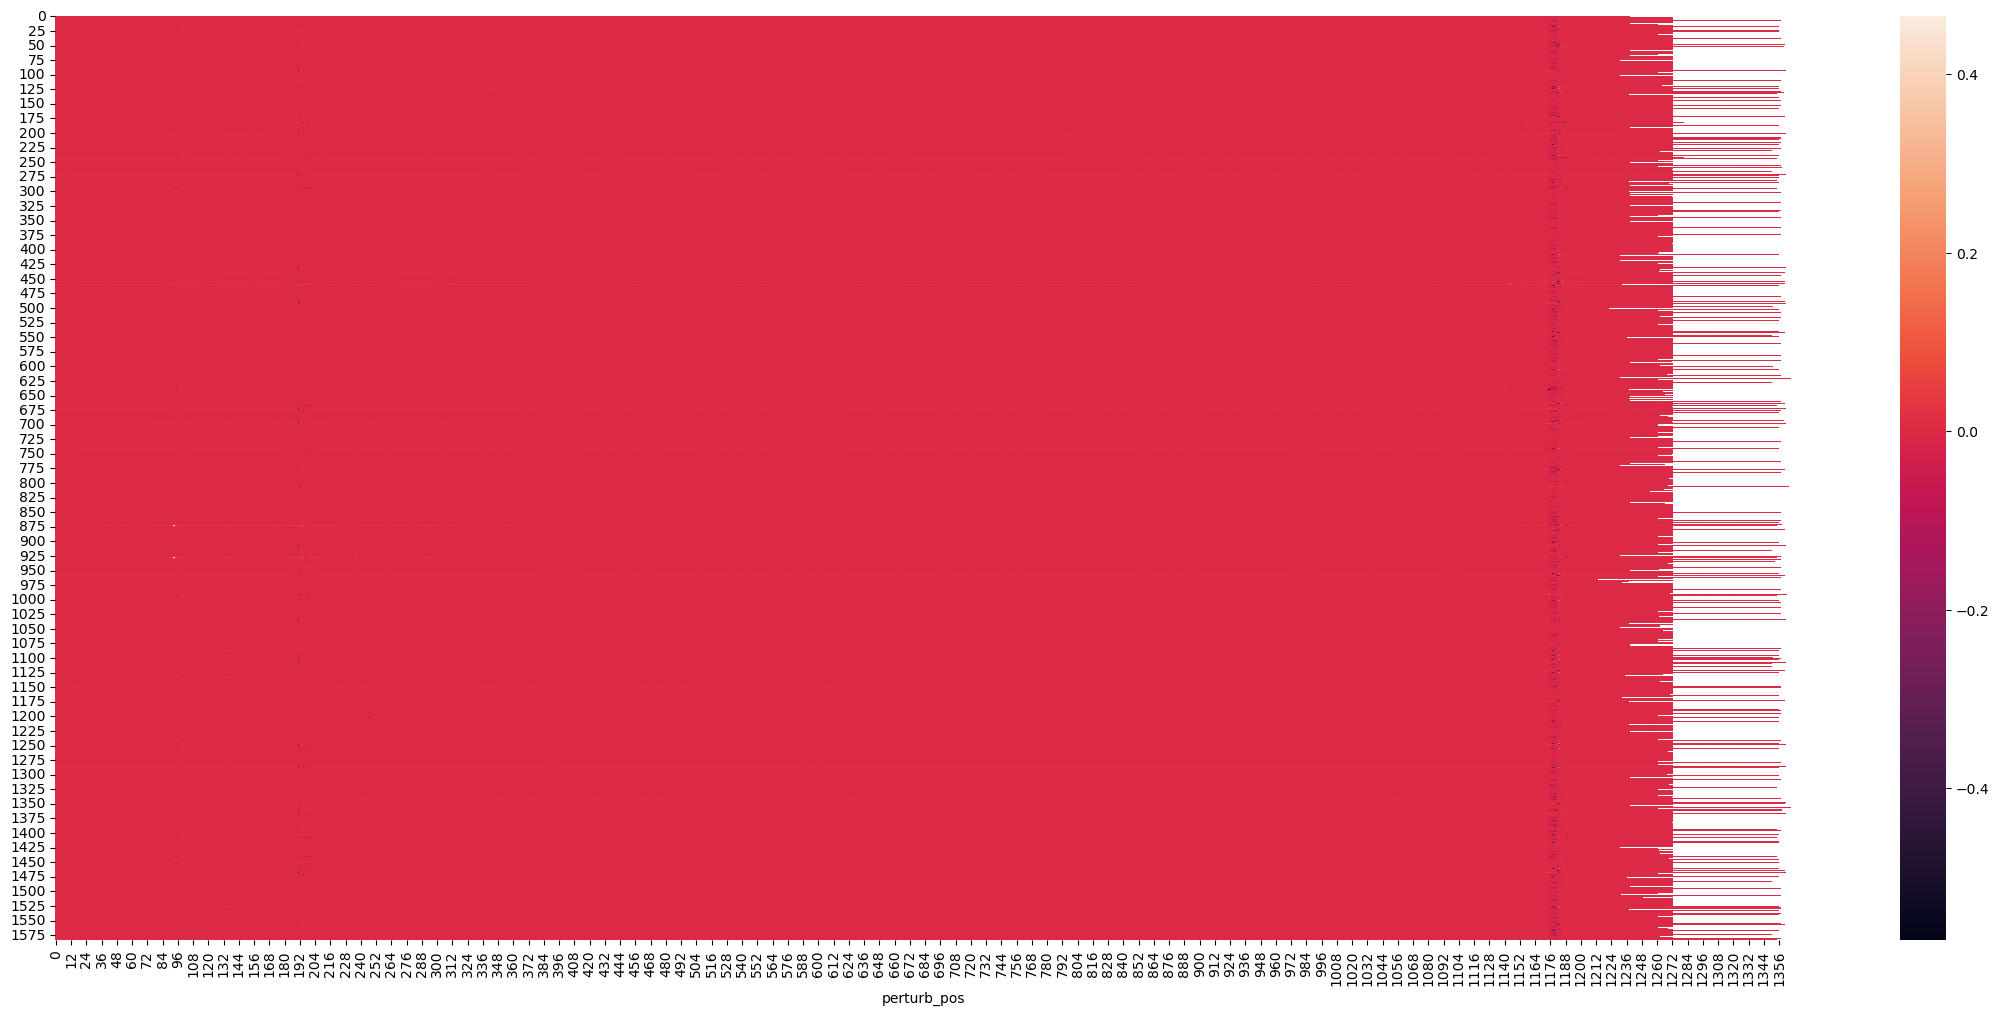

In [21]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.show()

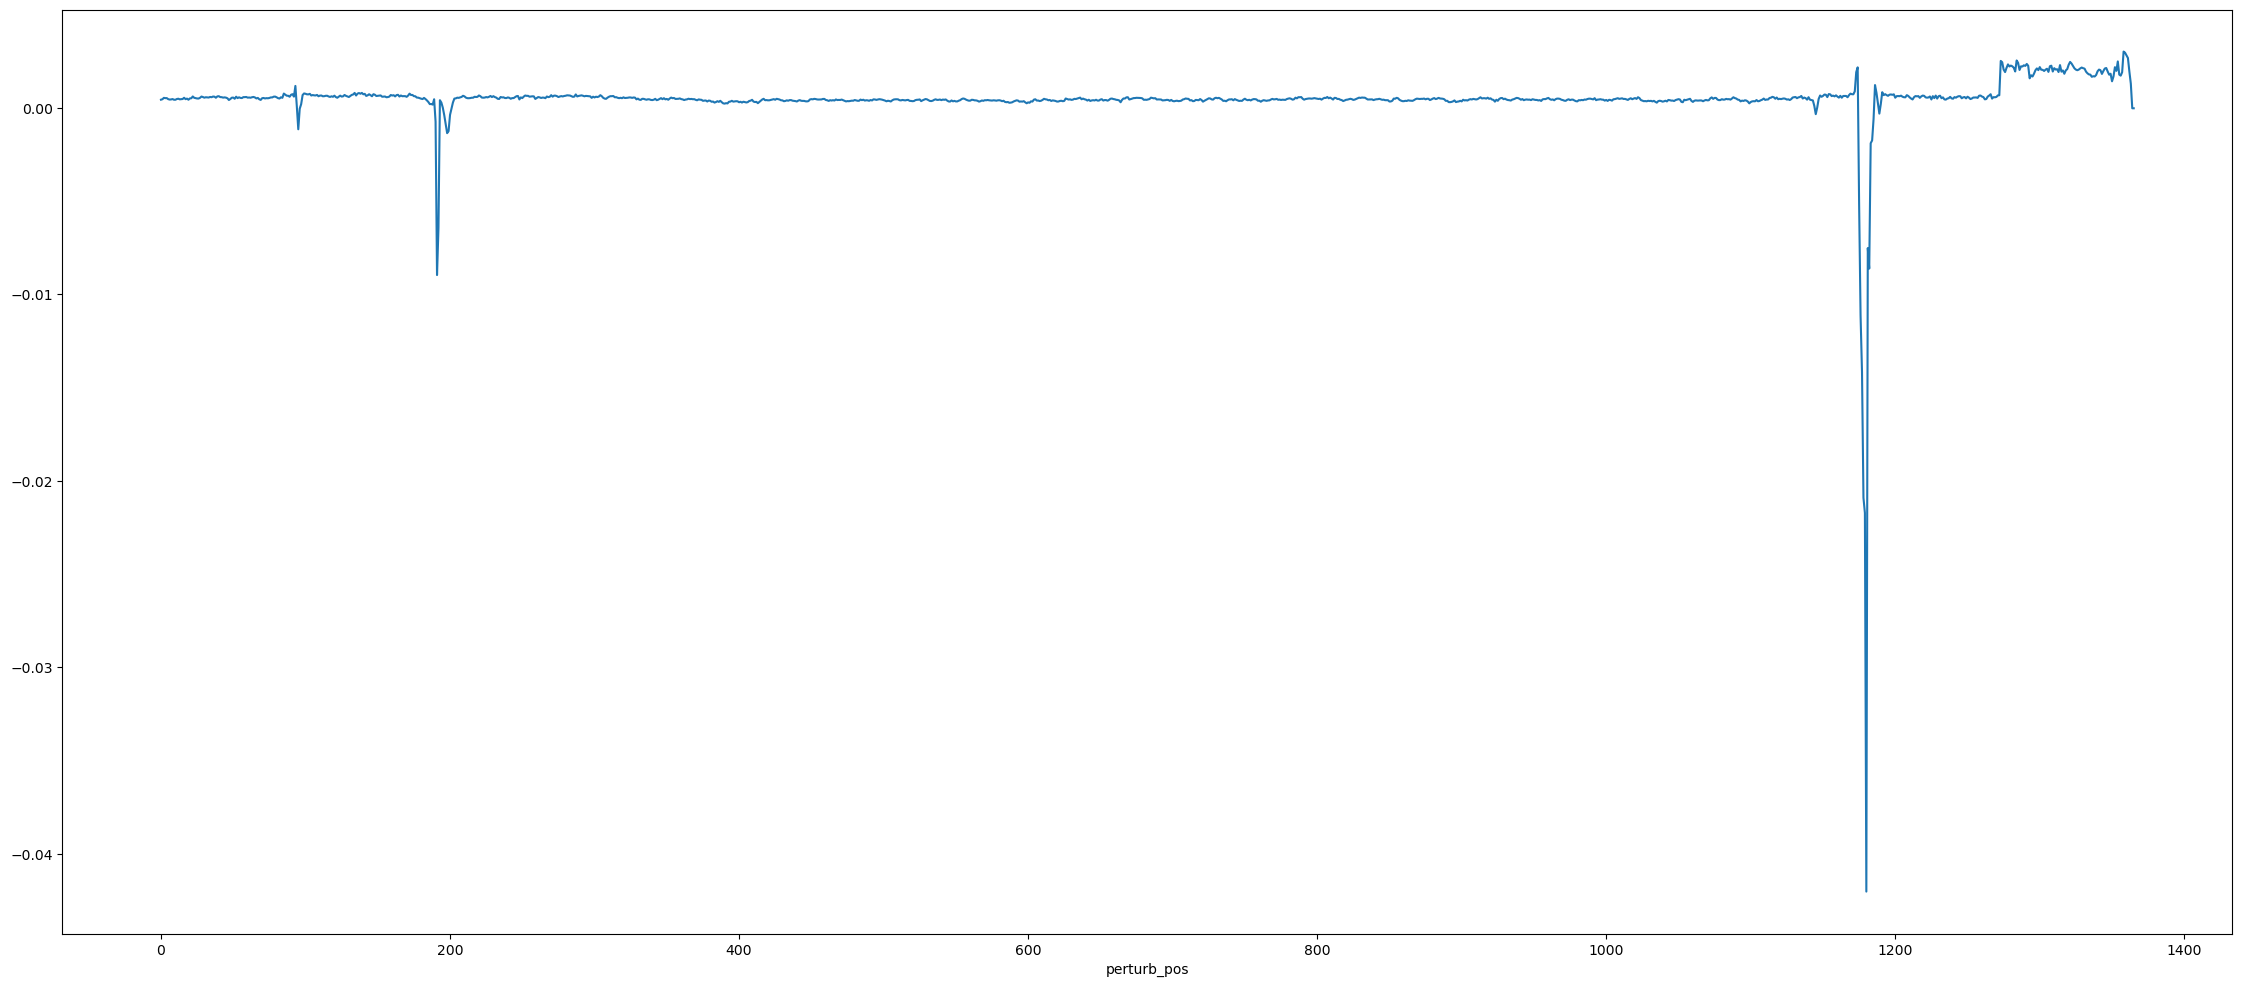

In [22]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.show()

In [23]:
mean_diff_df.mean(axis=0).idxmin()

1180

In [24]:
# retain only negative values i.e. probability of Human host decreases
mean_diff_df[mean_diff_df >= 0 ] = None

# drop all columns (positions) with atleast 10% non-NaN values i.e. this position does not decrease the probability for 90% or more of the sequences
# argument 'thresh': Require that many non-NA values.
mean_diff_df.dropna(axis=1, how="all", thresh=0.9*mean_diff_df.shape[0], inplace=True)

In [25]:
mean_diff_df.shape

(1584, 6)

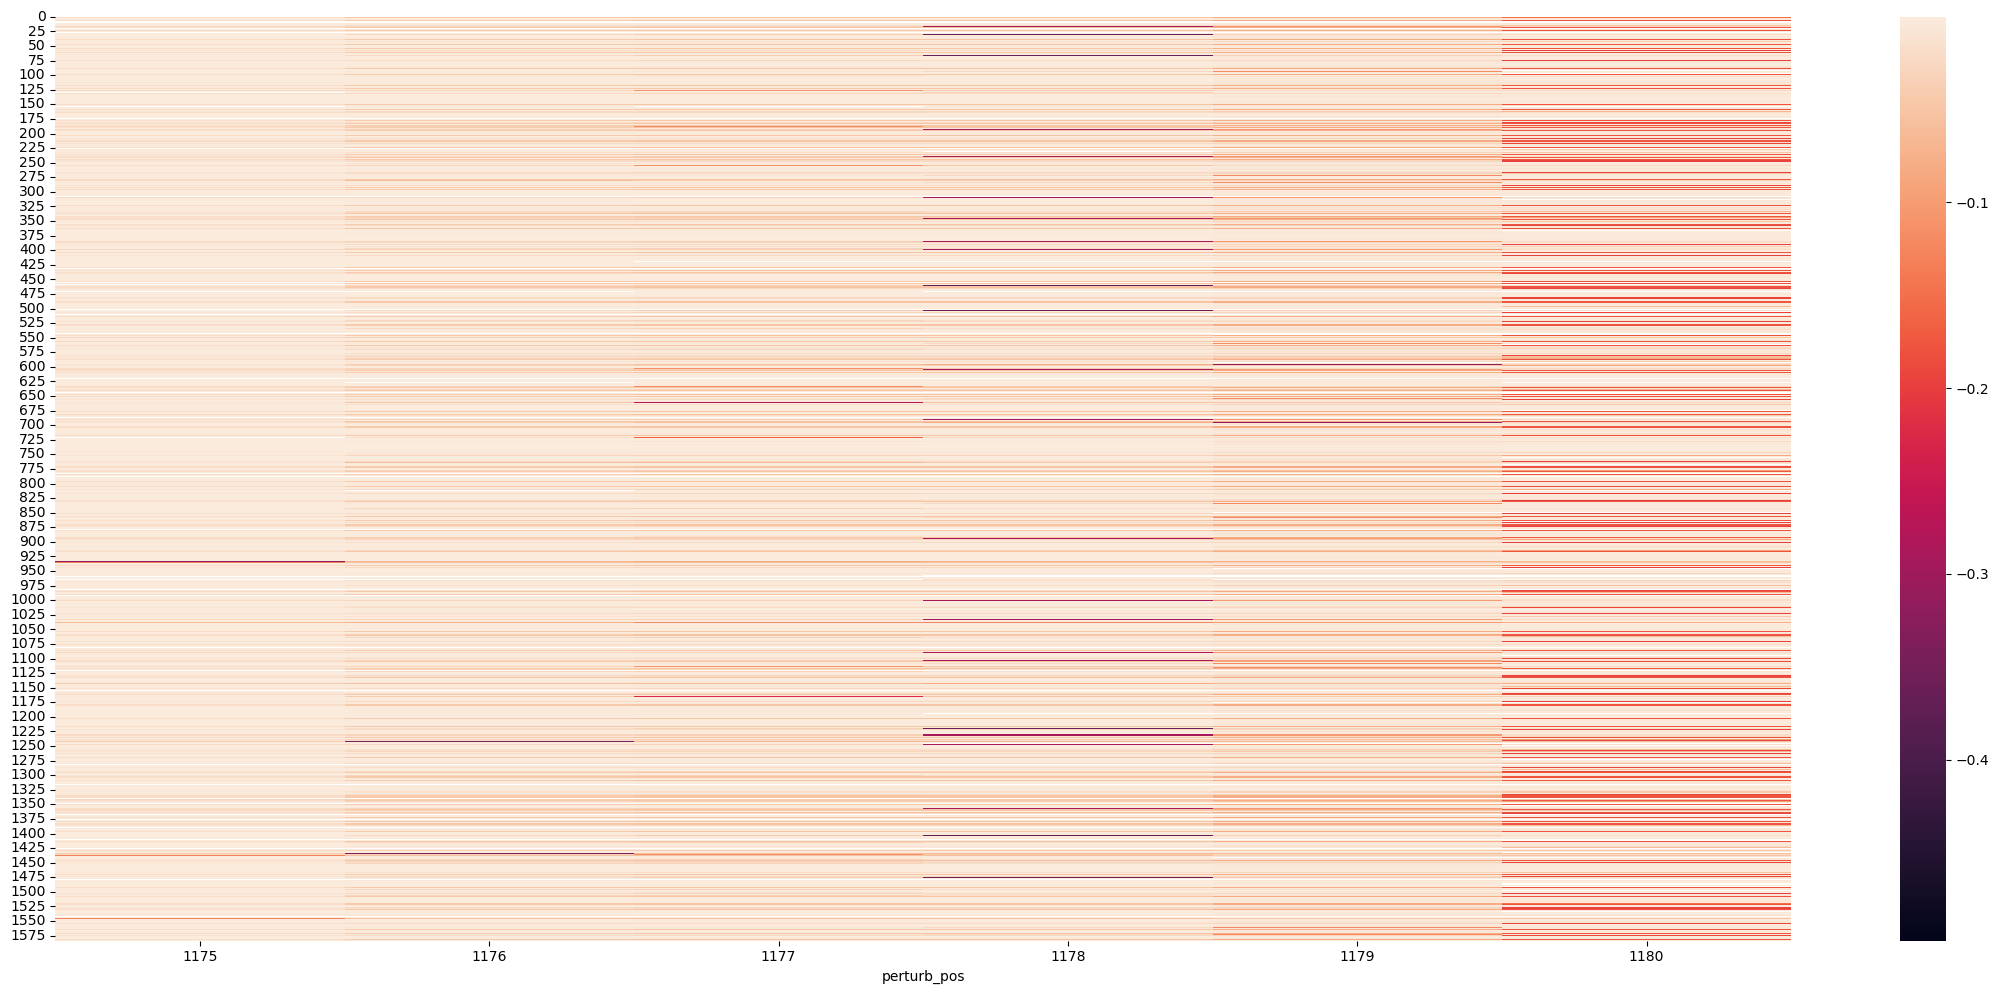

In [26]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.show()

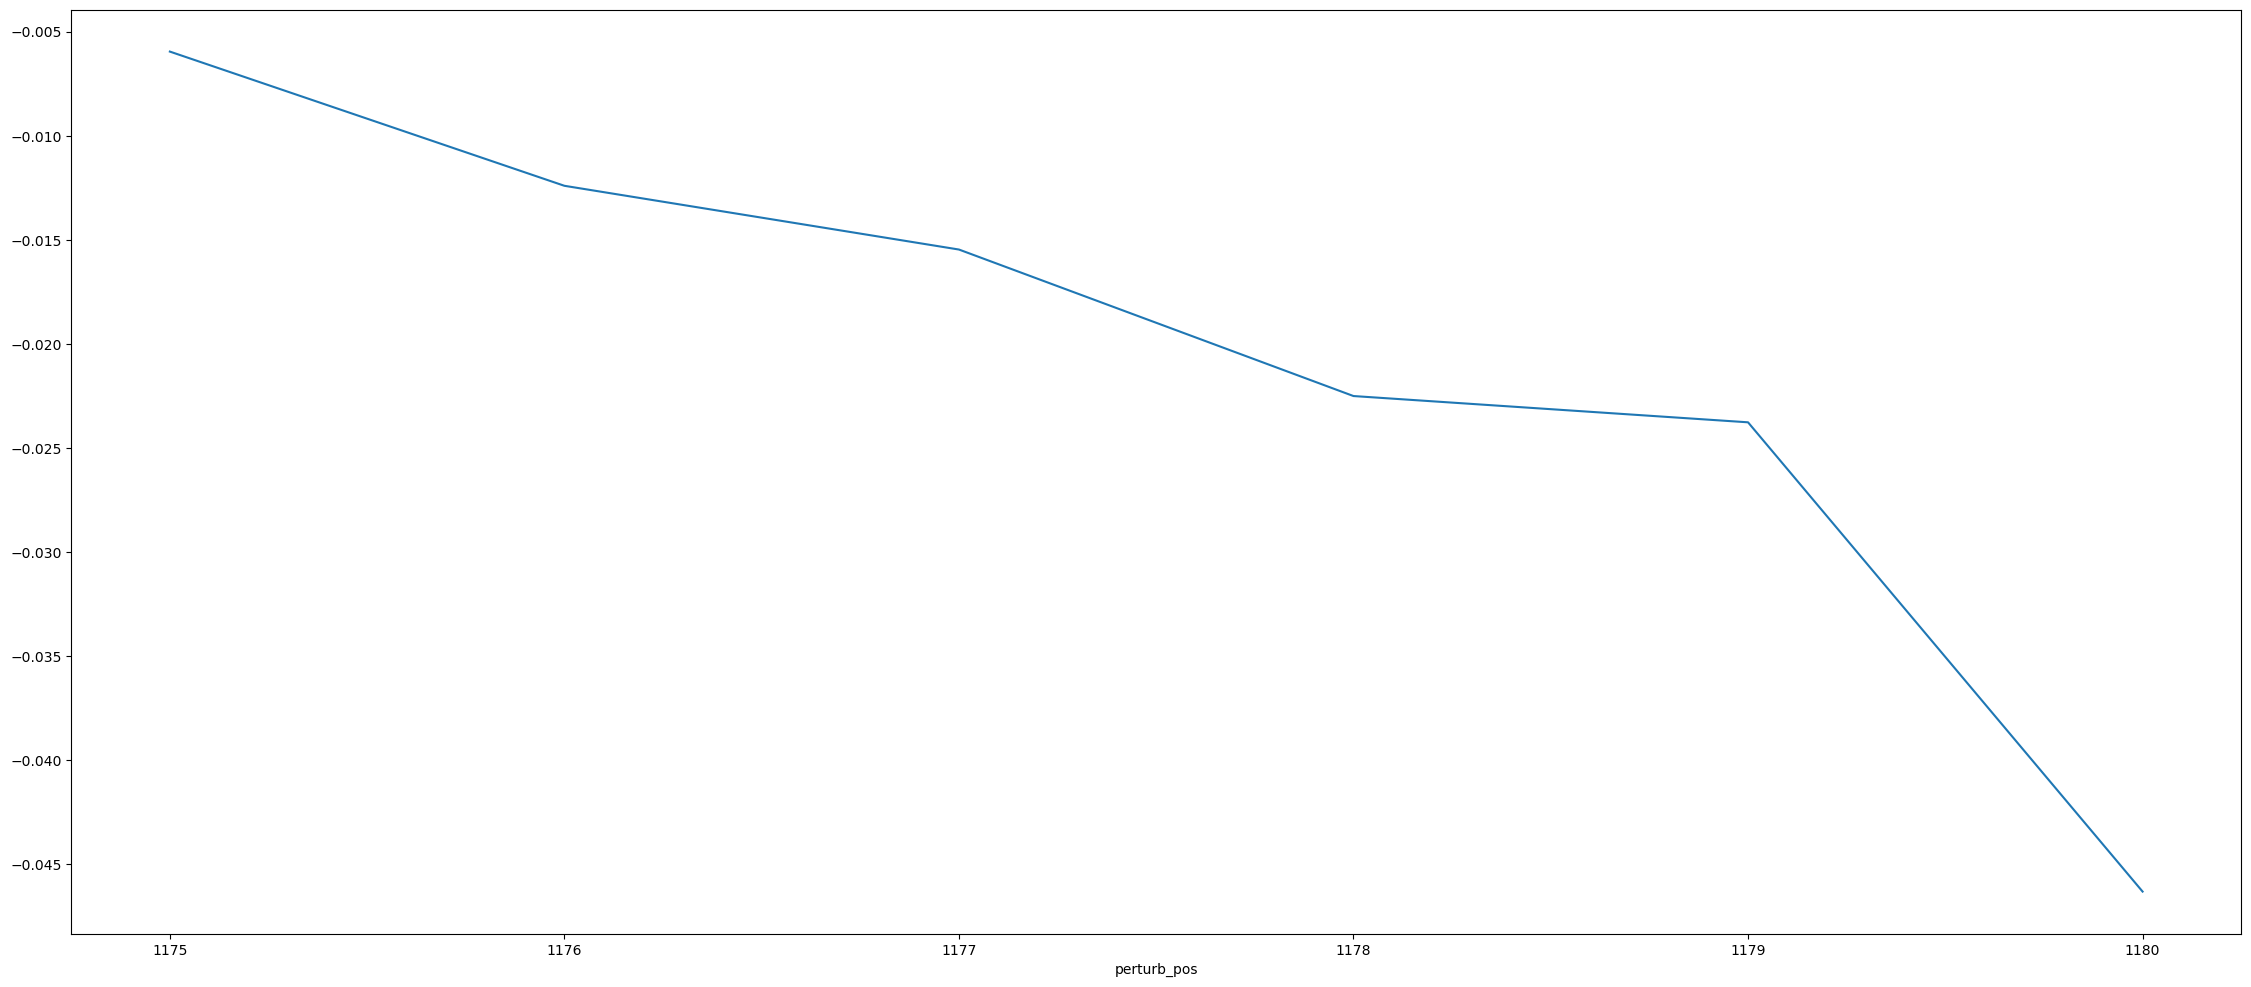

In [27]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.show()

In [28]:
mean_diff_df.mean(axis=0).nsmallest(10)

perturb_pos
1180   -0.046315
1179   -0.023772
1178   -0.022510
1177   -0.015472
1176   -0.012409
1175   -0.005962
dtype: float64

### A372T mutation in Wuhan Spike protein of SARS-CoV-2 infecting humans

In [21]:
w_sprot_input_filepath = "/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/sarscov2-S-WIV04ref.csv"
w_sprot_perturbed_output_filepath = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/sarscov2-S-WIV04/20230917/perturbed_dataset_prediction/transformer-l_6-h_8-lr1e-4/processed/tf_sarscov2-S-WIV04ref.csv_WIV04.csv"

In [17]:
df = pd.read_csv(w_sprot_input_filepath)
wuhan_seq = df["seq"][0]
df

id                                                seq  \
0  WIV04  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                         virus  seq_len  \
0  WIV04(MN996528.1) Wuhan variant index virus     1273   

                           virus_host binary_label  
0  Homo sapiens (Human) [TaxID: 9606]        Human

In [18]:
index_label_map, w_dataset_loader = get_token_dataset_loader(df, test_sequence_settings, label_settings)

Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

In [39]:
inputs, output_df = validate(tf_custom_model, w_dataset_loader, index_label_map)
perturbed_output_df = pd.read_csv(w_sprot_perturbed_output_filepath)

orig_seq_human_pred = output_df["Human"].values[0]
print(f"Prediction for human class for original sequence: {orig_seq_human_pred}")
perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
pivot_df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")

Prediction for human class for original sequence: 0.9322293400764465


In [41]:
print(f"Wuhan Sequence = {wuhan_seq}")
print(f"wuhan_seq pos 372 = wuhan_seq[371]: {wuhan_seq[371]}")
print(f"wuhan_seq pos 372 = wuhan_seq[372]: {wuhan_seq[372]}")
pivot_df[[370, 371, 372]]

Wuhan Sequence = MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSR

perturb_pos       370       371       372
new_token                                
A            0.000110       NaN  0.000110
B            0.000005 -0.000110 -0.000002
C            0.000158  0.000049  0.000161
D            0.000054 -0.000054  0.000060
E            0.000099 -0.000010  0.000102
F            0.000009 -0.000097  0.000019
G           -0.000047 -0.000159 -0.000049
H            0.000110 -0.000003  0.000108
I            0.000007 -0.000101  0.000014
J            0.000083 -0.000028  0.000082
K            0.000045 -0.000062  0.000053
L            0.000122  0.000017  0.000133
M            0.000016 -0.000093  0.000021
N            0.000014 -0.000098  0.000012
O            0.000031 -0.000080  0.000031
P            0.000146  0.000038  0.000150
Q            0.000054 -0.000054  0.000055
R            0.000074 -0.000034  0.000079
S                 NaN -0.000111       NaN
T            0.000049 -0.000058  0.000057
U           -0.000025 -0.000136 -0.000025
V            0.000160  0.000055  0.000169
W            0.000028 -0.000083  0.000028
X            0.004843  0.004608  0.004590
Y            0.000010 -0.000103  0.000007
Z           -0.000016 -0.000125 -0.000013

In [23]:
perturbed_output_df

Human     id orig_token  perturb_pos new_token  pred_diff
0      0.940967  WIV04          S          967         X   0.008738
1      0.932118  WIV04          E         1201         K  -0.000112
2      0.932244  WIV04          S          690         M   0.000015
3      0.932197  WIV04          P         1052         H  -0.000032
4      0.932189  WIV04          N          120         U  -0.000040
...         ...    ...        ...          ...       ...        ...
31821  0.932369  WIV04          S          812         H   0.000140
31822  0.932148  WIV04          Q          754         U  -0.000082
31823  0.932357  WIV04          N           60         A   0.000128
31824  0.932209  WIV04          T         1026         N  -0.000020
31825  0.932203  WIV04          I          930         Z  -0.000026

[31826 rows x 6 columns]

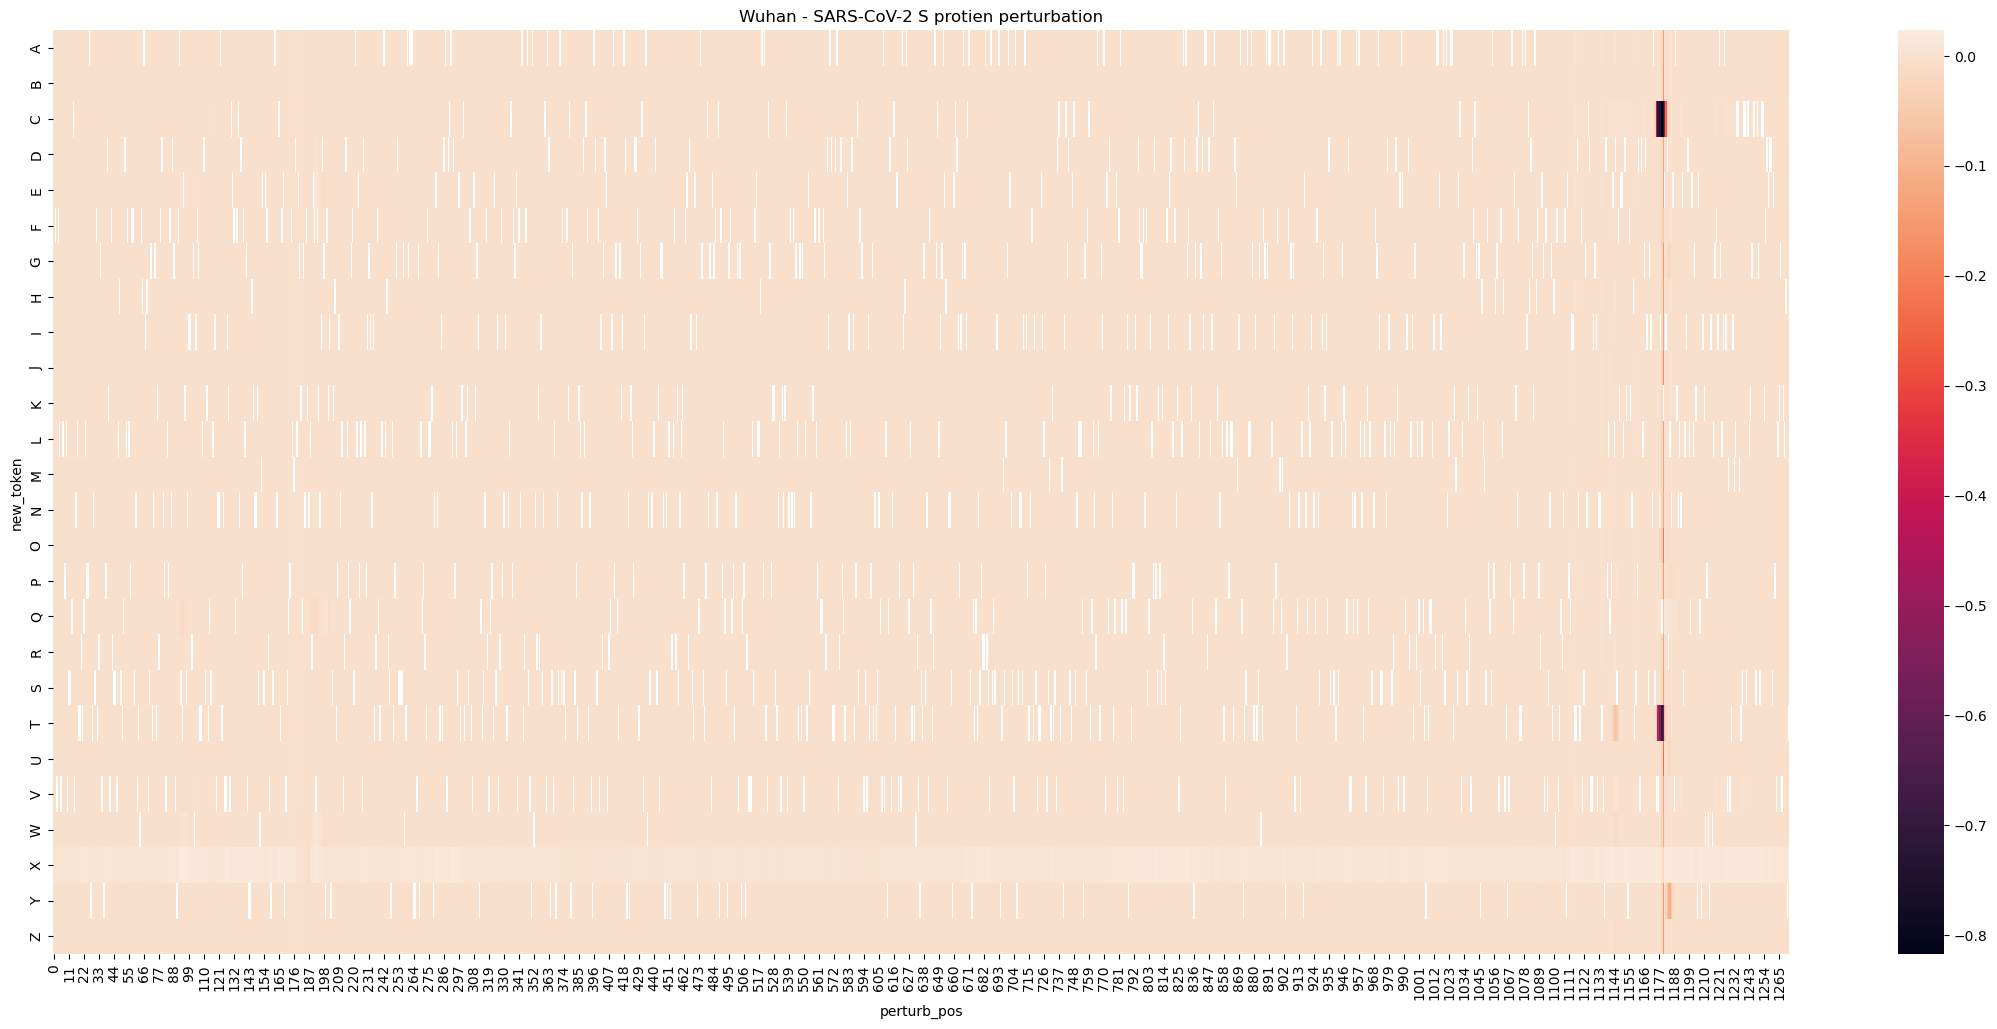

In [33]:
plt.figure(figsize=(28,12))
ax = sns.heatmap(pivot_df)
ax.set_title("Wuhan - SARS-CoV-2 S protien perturbation")
plt.show()

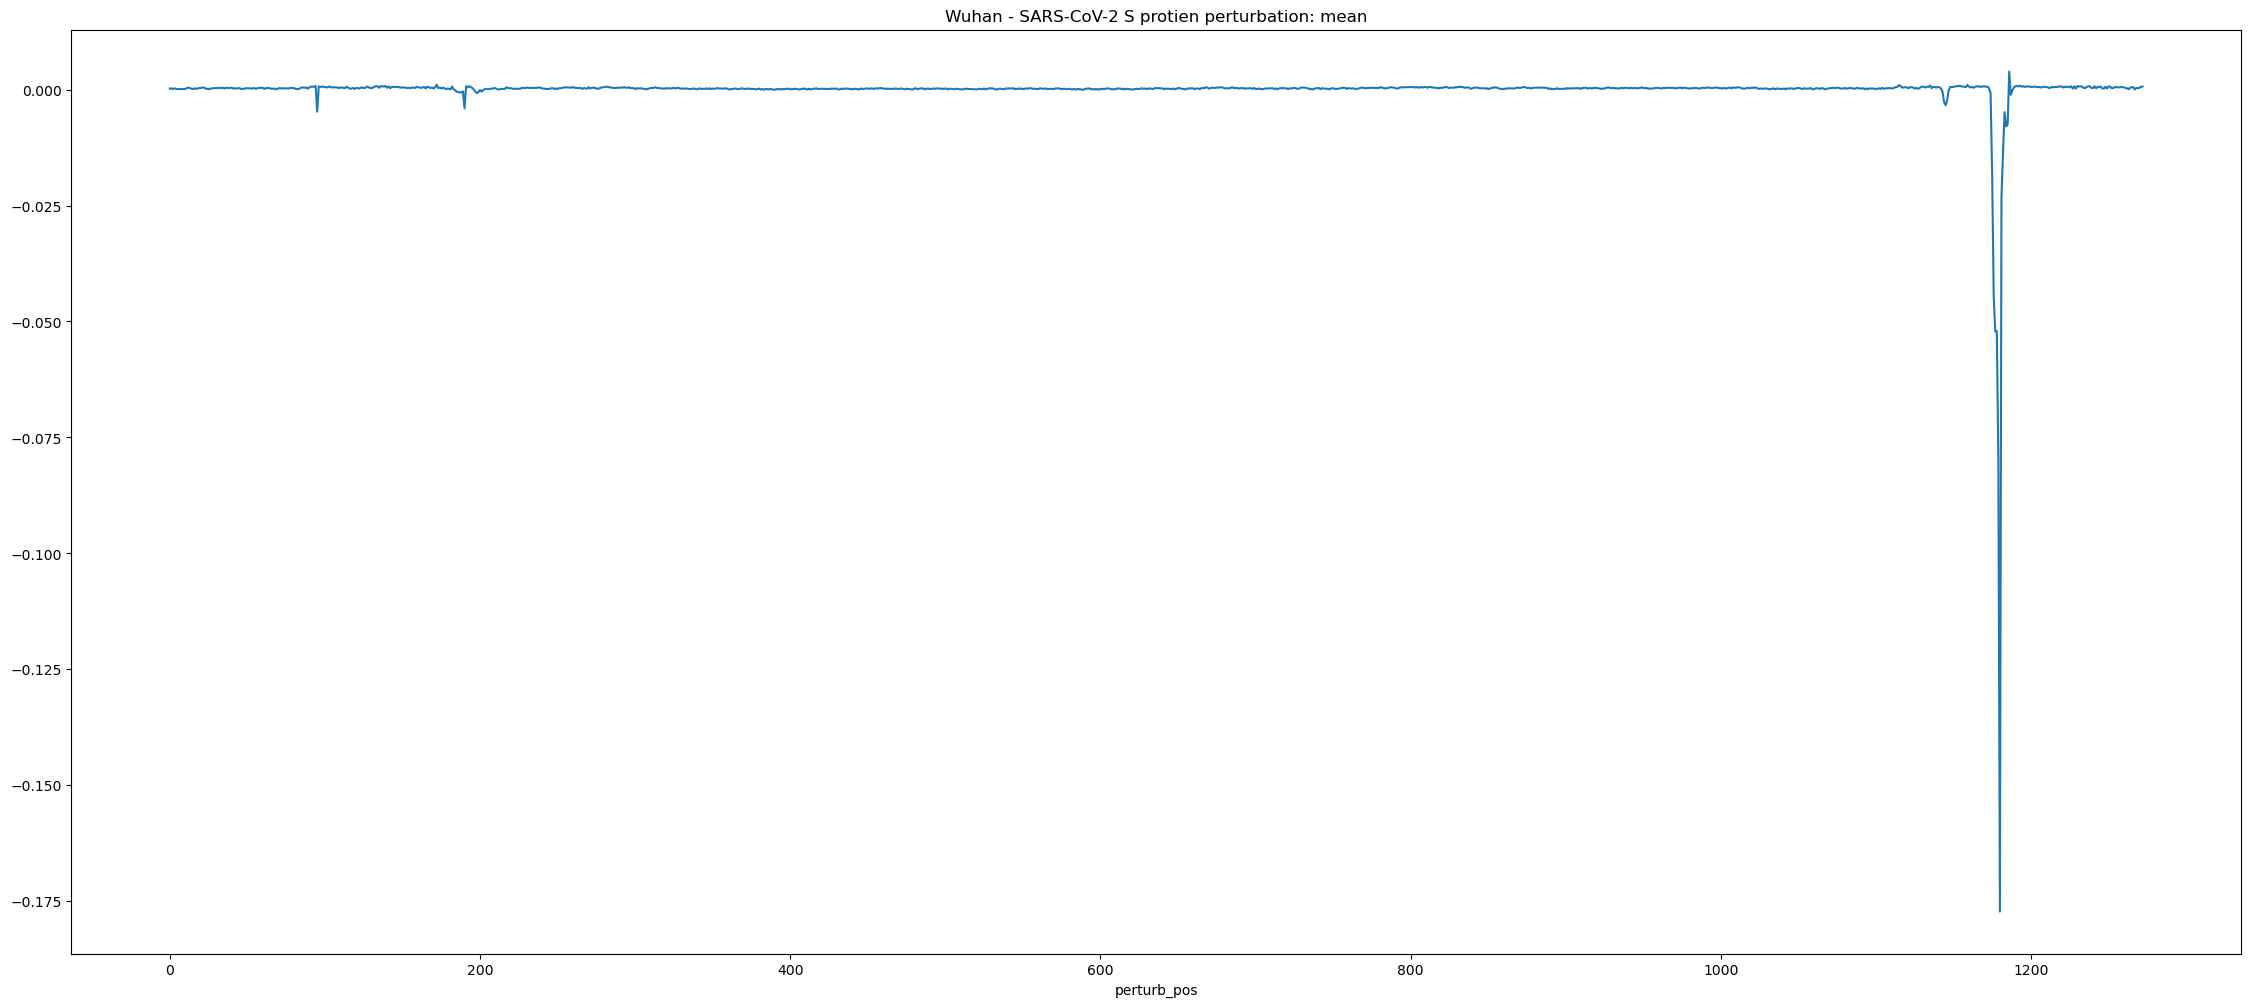

In [25]:
plt.figure(figsize=(28,12))
ax = sns.lineplot(df.mean(axis=0))
ax.set_title("Wuhan - SARS-CoV-2 S protien perturbation: mean")
plt.show()

In [30]:
df = pd.read_csv(w_sprot_input_filepath)


In [31]:
wuhan_seq

'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITG

In [32]:
wuhan_seq[371]

'A'

perturb_pos          0         1         2         3         4         5     \
new_token                                                                     
A            1.025599e-04  0.000098 -0.000049  0.000095  0.000029 -0.000050   
B            2.999236e-07 -0.000005 -0.000154 -0.000011 -0.000078 -0.000158   
C            1.578599e-04  0.000157  0.000013  0.000158  0.000089  0.000005   
D            2.695992e-05  0.000024 -0.000124  0.000017 -0.000054 -0.000136   
E            7.615992e-05  0.000075 -0.000073  0.000064 -0.000011 -0.000094   
F            2.059924e-06       NaN -0.000145       NaN -0.000070 -0.000153   
G           -5.234008e-05 -0.000060 -0.000211 -0.000068 -0.000135 -0.000215   
H            9.089992e-05  0.000088 -0.000060  0.000083  0.000016 -0.000064   
I           -1.254008e-05 -0.000016 -0.000163 -0.000020 -0.000089 -0.000171   
J            6.005992e-05  0.000056 -0.000091  0.000053 -0.000016 -0.000095   
K            1.545992e-05  0.000015 -0.000130  0.000011 -0.000060 -0.000142   
L            8.069992e-05  0.000084 -0.000063  0.000073       NaN -0.000077   
M           -1.400764e-07 -0.000004 -0.000151 -0.000007 -0.000076 -0.000156   
N           -1.544008e-05 -0.000019 -0.000166 -0.000023 -0.000093 -0.000174   
O            1.335992e-05  0.000011 -0.000136  0.000008 -0.000060 -0.000141   
P            1.265999e-04  0.000124 -0.000024  0.000118  0.000048 -0.000032   
Q            3.730992e-05  0.000027 -0.000134  0.000002 -0.000061 -0.000127   
R            5.399992e-05  0.000051 -0.000097  0.000046 -0.000023 -0.000103   
S           -2.581008e-05 -0.000032 -0.000178 -0.000031 -0.000095 -0.000174   
T            1.459924e-06 -0.000003 -0.000149 -0.000001 -0.000068 -0.000148   
U           -3.409008e-05 -0.000038 -0.000185 -0.000040 -0.000107 -0.000187   
V            1.428099e-04  0.000145       NaN  0.000141  0.000074       NaN   
W           -7.644652e-11 -0.000003 -0.000149 -0.000006 -0.000077 -0.000159   
X            5.291160e-03  0.006219  0.006651  0.006626  0.005959  0.005352   
Y           -9.840076e-06 -0.000015 -0.000162 -0.000016 -0.000082 -0.000163   
Z           -5.034008e-05 -0.000054 -0.000202 -0.000058 -0.000125 -0.000204   

perturb_pos      6         7         8         9     ...      1263      1264  \
new_token                                            ...                       
A            0.000017  0.000004 -0.000024 -0.000009  ... -0.000235  0.000086   
B           -0.000093 -0.000108 -0.000136 -0.000117  ... -0.000395 -0.000070   
C            0.000069  0.000056  0.000030  0.000052  ... -0.000162  0.000173   
D           -0.000069 -0.000080 -0.000104 -0.000084  ... -0.000378 -0.000055   
E           -0.000025 -0.000035 -0.000059 -0.000039  ... -0.000296  0.000032   
F           -0.000089 -0.000103 -0.000129 -0.000110  ... -0.000402 -0.000076   
G           -0.000149 -0.000162 -0.000189 -0.000170  ... -0.000463 -0.000144   
H            0.000003 -0.000009 -0.000035 -0.000016  ... -0.000286  0.000038   
I           -0.000105 -0.000116 -0.000142 -0.000124  ... -0.000424 -0.000099   
J           -0.000028 -0.000039 -0.000064 -0.000043  ... -0.000299  0.000027   
K           -0.000075 -0.000084 -0.000109 -0.000092  ... -0.000388 -0.000062   
L                 NaN       NaN -0.000018       NaN  ... -0.000345       NaN   
M           -0.000089 -0.000101 -0.000128 -0.000113  ... -0.000405 -0.000080   
N           -0.000108 -0.000122 -0.000149 -0.000131  ... -0.000456 -0.000131   
O           -0.000074 -0.000087 -0.000114 -0.000095  ... -0.000353 -0.000027   
P            0.000036  0.000025       NaN  0.000020  ... -0.000237  0.000090   
Q           -0.000051 -0.000064 -0.000097 -0.000084  ... -0.000298  0.000026   
R           -0.000035 -0.000047 -0.000073 -0.000055  ... -0.000336 -0.000011   
S           -0.000108 -0.000121 -0.000149 -0.000133  ... -0.000437 -0.000112   
T           -0.000083 -0.000096 -0.000119 -0.000098  ... -0.000410 -0.000082   
U           -0.000123 -0.00

perturb_pos       370       371       372
new_token                                
A            0.000110       NaN  0.000110
B            0.000005 -0.000110 -0.000002
C            0.000158  0.000049  0.000161
D            0.000054 -0.000054  0.000060
E            0.000099 -0.000010  0.000102
F            0.000009 -0.000097  0.000019
G           -0.000047 -0.000159 -0.000049
H            0.000110 -0.000003  0.000108
I            0.000007 -0.000101  0.000014
J            0.000083 -0.000028  0.000082
K            0.000045 -0.000062  0.000053
L            0.000122  0.000017  0.000133
M            0.000016 -0.000093  0.000021
N            0.000014 -0.000098  0.000012
O            0.000031 -0.000080  0.000031
P            0.000146  0.000038  0.000150
Q            0.000054 -0.000054  0.000055
R            0.000074 -0.000034  0.000079
S                 NaN -0.000111       NaN
T            0.000049 -0.000058  0.000057
U           -0.000025 -0.000136 -0.000025
V            0.000160  0.000055  0.000169
W            0.000028 -0.000083  0.000028
X            0.004843  0.004608  0.004590
Y            0.000010 -0.000103  0.000007
Z           -0.000016 -0.000125 -0.000013